# Decision Tree & Random Forest for WU Data

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import random
import datetime
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from prettytable import PrettyTable

# Ignore useless warnings 
import warnings
warnings.filterwarnings(action="ignore")    


In [2]:
import os
os.getcwd()

'/Users/danny/Desktop/MDS/master 4/CITS 5553 Data Science Capstone Project/Individual/Capstone-Individual/Data Modeling/WU'

## Read Data

In [3]:
os.chdir('/Users/danny/Desktop/MDS/master 4/CITS 5553 Data Science Capstone Project/Individual/Capstone-Individual/Data')

In [4]:
df = pd.read_csv('aemo_wu_merged.csv', index_col = 0)
df.head()

,timestamp,Operational Demand (MW),temperature(celcius),dew_point(celcius),humidity(%),Wind,wind_speed(mph),wind_gush(mph),pressure(in),precip.(in),Condition
0,2017-01-22 00:00:00,1815.214,20.0,15.0,73.0,SSW,9.0,0.0,29.0,0.0,Fair
1,2017-01-22 00:30:00,1777.040,20.0,15.0,73.0,SSW,10.0,0.0,29.0,0.0,Fair
2,2017-01-22 01:00:00,1745.448,18.9,15.0,78.0,SSW,9.0,0.0,29.0,0.0,Fair
3,2017-01-22 01:30:00,1729.164,18.9,15.0,78.0,SSW,15.0,0.0,29.0,0.0,Fair
4,2017-01-22 02:00:00,1714.276,18.9,12.8,68.0,SSW,18.0,0.0,29.0,0.0,Fair


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97504 entries, 0 to 97503
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                97504 non-null  object 
 1   Operational Demand (MW)  97504 non-null  float64
 2   temperature(celcius)     97504 non-null  float64
 3   dew_point(celcius)       97504 non-null  float64
 4   humidity(%)              97504 non-null  float64
 5   Wind                     97504 non-null  object 
 6   wind_speed(mph)          97504 non-null  float64
 7   wind_gush(mph)           97504 non-null  float64
 8   pressure(in)             97504 non-null  float64
 9   precip.(in)              97504 non-null  float64
 10  Condition                97504 non-null  object 
dtypes: float64(8), object(3)
memory usage: 8.9+ MB


In [6]:
df.columns

Index(['timestamp', 'Operational Demand (MW)', 'temperature(celcius)',
       'dew_point(celcius)', 'humidity(%)', 'Wind', 'wind_speed(mph)',
       'wind_gush(mph)', 'pressure(in)', 'precip.(in)', 'Condition'],
      dtype='object')

## Data Preparation

In [7]:
# Seperate timestamp and set several new variables
def wind_ans(x):
    if x > 0: 
        return 1 
    else:
        return 0
# split time into date and interval timedf['Date'] = pd.to_datetime(df['Date'])
df[['Date','Trading Interval Time']] = df['timestamp'].str.split(" ",expand=True)
df['Date'] = pd.to_datetime(df['Date'])
df['new_timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['year'] = df['new_timestamp'].dt.year
df['month'] = df['new_timestamp'].dt.month
df['day'] = df['new_timestamp'].dt.day
df['hour'] = df['new_timestamp'].dt.hour
df['minute'] = df['new_timestamp'].dt.minute
df['Day_of_week'] = df['new_timestamp'].dt.dayofweek
df['Day_of_month'] = df['new_timestamp'].dt.day
df['Day_of_year'] = df['new_timestamp'].dt.dayofyear
df['has_Wind'] = df['wind_speed(mph)'].apply(wind_ans) 
df.set_index('timestamp', inplace=True, drop=True)
df.reset_index(inplace=True)
df.head()

,timestamp,Operational Demand (MW),temperature(celcius),dew_point(celcius),humidity(%),Wind,wind_speed(mph),wind_gush(mph),pressure(in),precip.(in),...,new_timestamp,year,month,day,hour,minute,Day_of_week,Day_of_month,Day_of_year,has_Wind
0,2017-01-22 00:00:00,1815.214,20.0,15.0,73.0,SSW,9.0,0.0,29.0,0.0,...,2017-01-22 00:00:00,2017,1,22,0,0,6,22,22,1
1,2017-01-22 00:30:00,1777.040,20.0,15.0,73.0,SSW,10.0,0.0,29.0,0.0,...,2017-01-22 00:30:00,2017,1,22,0,30,6,22,22,1
2,2017-01-22 01:00:00,1745.448,18.9,15.0,78.0,SSW,9.0,0.0,29.0,0.0,...,2017-01-22 01:00:00,2017,1,22,1,0,6,22,22,1
3,2017-01-22 01:30:00,1729.164,18.9,15.0,78.0,SSW,15.0,0.0,29.0,0.0,...,2017-01-22 01:30:00,2017,1,22,1,30,6,22,22,1
4,2017-01-22 02:00:00,1714.276,18.9,12.8,68.0,SSW,18.0,0.0,29.0,0.0,...,2017-01-22 02:00:00,2017,1,22,2,0,6,22,22,1


In [8]:
# def create_time_features(df_in):
#     df = df_in
#     df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
#     df['Year'] = df['timestamp'].dt.year
#     df['Month'] = df['timestamp'].dt.month
#     df['Hour'] = df['timestamp'].dt.hour
#     df['Day_of_week'] = df['timestamp'].dt.dayofweek
#     df['Day_of_month'] = df['timestamp'].dt.day
#     df['Day_of_year'] = df['timestamp'].dt.dayofyear
#     df.set_index('timestamp', inplace=True, drop=True)
#     # df = df.astype('int')
#     df.reset_index(inplace=True)
#     time_features_df = df
#     return time_features_df
# df_a = create_time_features(df)
# df_a.columns.tolist()
# df_a.head()

In [9]:
#select_col=['Operational Demand (MW)', 'temperature(celcius)', 'dew_point(celcius)', 'humidity(%)', 'wind_speed(mph)', 'year','Day_of_week','Day_of_month','Day_of_year']
df.index = df['timestamp']
select_col = ['Operational Demand (MW)', 'temperature(celcius)', 'dew_point(celcius)', 'humidity(%)', 'wind_speed(mph)', 'wind_gush(mph)', 'pressure(in)',
'Day_of_week', 'Day_of_month', 'Day_of_year','year','month','day','hour','minute']
y_col=['Operational Demand (MW)']
x_col=list(set(select_col)-set(y_col))
model_df=df[select_col]
# training_dat = model_df[(model_df.index < '2020-12-01') | ('2021-04-01' <= model_df.index)]
training_dat = model_df[model_df.index < '2020-12-01']
testing_dat = model_df[(model_df.index >= '2020-12-01') & ('2021-04-01' > model_df.index)]

X_train = training_dat.drop('Operational Demand (MW)',axis=1)
y_train = training_dat['Operational Demand (MW)']

X_test = testing_dat.drop('Operational Demand (MW)', axis = 1) 
y_test = testing_dat['Operational Demand (MW)']


In [10]:
X_train[X_train.index < '2020-12-01']

,temperature(celcius),dew_point(celcius),humidity(%),wind_speed(mph),wind_gush(mph),pressure(in),Day_of_week,Day_of_month,Day_of_year,year,month,day,hour,minute
timestamp,,,,,,,,,,,,,,
2017-01-22 00:00:00,20.0,15.0,73.0,9.0,0.0,29.0,6,22,22,2017,1,22,0,0
2017-01-22 00:30:00,20.0,15.0,73.0,10.0,0.0,29.0,6,22,22,2017,1,22,0,30
2017-01-22 01:00:00,18.9,15.0,78.0,9.0,0.0,29.0,6,22,22,2017,1,22,1,0
2017-01-22 01:30:00,18.9,15.0,78.0,15.0,0.0,29.0,6,22,22,2017,1,22,1,30
2017-01-22 02:00:00,18.9,12.8,68.0,18.0,0.0,29.0,6,22,22,2017,1,22,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-30 21:30:00,12.8,6.1,63.0,9.0,0.0,30.0,0,30,335,2020,11,30,21,30
2020-11-30 22:00:00,12.2,6.1,67.0,8.0,0.0,30.0,0,30,335,2020,11,30,22,0
2020-11-30 22:30:00,10.0,6.1,76.0,7.0,0.0,30.0,0,30,335,2020,11,30,22,30


## Function Preparation

In [11]:
def ModelScore(true,predict):
    print("Mean absolute error = ",round(sm.mean_absolute_error(true,predict),4))
    print("Mean squared error = ",round(sm.mean_squared_error(true,predict),4))
    print("Median absolute error = ",round(sm.median_absolute_error(true,predict),4))
    print("explained variance error = ",round(sm.explained_variance_score(true,predict),4))
    print("R2 error = ",round(sm.r2_score(true,predict),4))

def ImportanceDisplay(model):
    if 'grid' in model:
        impo_lst=[model,'.best_estimator_.feature_importances_']
    else:
        impo_lst=[model,'.feature_importances_']
    impo_str=''
    importance = eval(impo_str.join(impo_lst))
    #importance = rf_reg.feature_importances_
    table = PrettyTable(['Factors','Score'])
    for i,v in enumerate(importance):
	    table.add_row([x_col[i],round(v,4)])
    print(table)

## Feature Scale

In [12]:
# stdsc=StandardScaler()
# X_train_sc = stdsc.fit_transform(X_train)
# X_test_sc = stdsc.transform(X_test)

## Decision Tree

In [13]:
tree_reg = DecisionTreeRegressor(criterion='mse', random_state=42)

param_grid_dtree = dict(
    max_depth =[None,15,20,25],
    min_samples_leaf=[5,50,100])

grid_dtree=GridSearchCV(tree_reg, param_grid_dtree, cv=3, scoring='neg_root_mean_squared_error',verbose=2,return_train_score=True)

grid_dtree.fit(X_train,y_train)
y_pred_tree = grid_dtree.predict(X_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.2s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.2s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.2s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.2s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.2s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.1s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.1s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.1s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.1s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=   0.2s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=   0.2s
[CV] END ...................max_depth=15, min_sa

In [14]:
dtscore=ModelScore(y_test,y_pred_tree)
dtscore
ny_test=len(y_test)
mape = (sum(np.abs((y_test - y_pred_tree)/y_test))/ny_test)*100
print('Mape', mape)
ImportanceDisplay('grid_dtree')
print(grid_dtree.best_estimator_)

Mean absolute error =  166.5394
Mean squared error =  51675.4474
Median absolute error =  123.0893
explained variance error =  0.7697
R2 error =  0.7668
Mape 8.15728962831032
+----------------------+--------+
|       Factors        | Score  |
+----------------------+--------+
|     Day_of_week      | 0.2319 |
|         day          | 0.0331 |
|   wind_speed(mph)    | 0.0119 |
|        minute        | 0.0013 |
|     Day_of_year      |  0.0   |
|        month         | 0.0022 |
|     humidity(%)      | 0.0516 |
|  dew_point(celcius)  | 0.002  |
| temperature(celcius) | 0.0845 |
|    wind_gush(mph)    | 0.0296 |
|     pressure(in)     | 0.0011 |
|     Day_of_month     | 0.0022 |
|         year         | 0.5454 |
|         hour         | 0.0034 |
+----------------------+--------+
DecisionTreeRegressor(criterion='mse', min_samples_leaf=50, random_state=42)


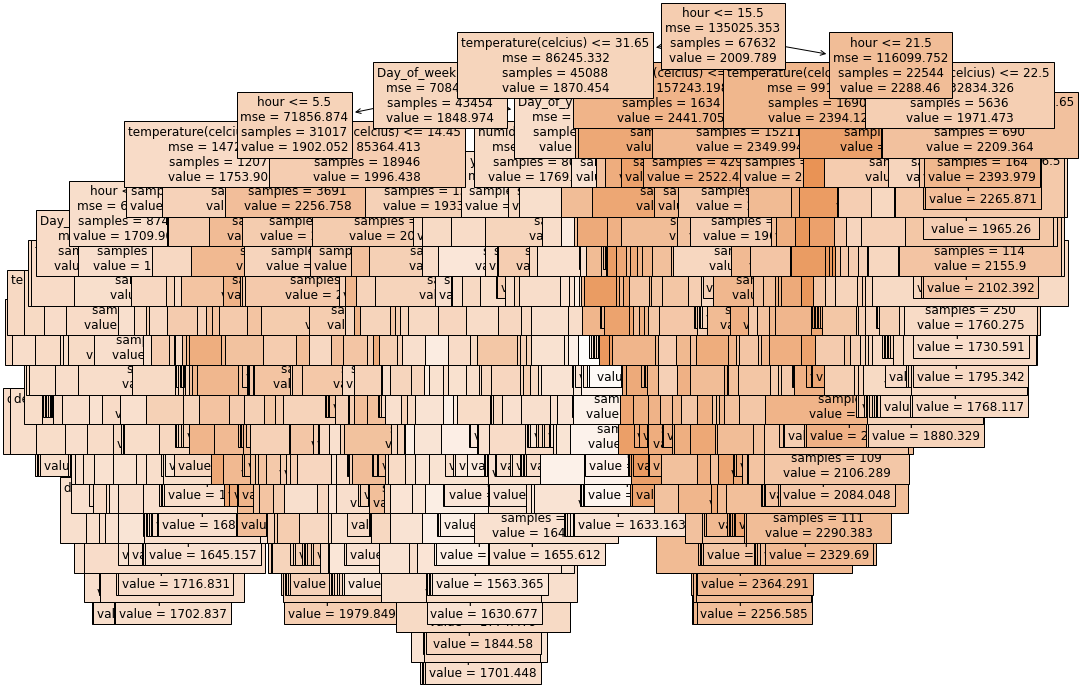

In [15]:
fig = plt.figure(figsize=(16,12))
a_rf_smote = plot_tree(grid_dtree.best_estimator_, feature_names=X_train.columns, fontsize=12, filled=True, class_names=['0', '1'])

In [16]:
y_pred_tree = pd.DataFrame(y_pred_tree)
predict_table_tree = pd.DataFrame(y_test)
predict_table_tree.insert(1,'predict',y_pred_tree)
predict_table_tree

,Operational Demand (MW),predict
timestamp,,
2020-12-01 00:00:00,1750.880,1743.069774
2020-12-01 00:30:00,1709.428,1743.069774
2020-12-01 01:00:00,1708.242,1847.656328
2020-12-01 01:30:00,1692.028,1847.656328
2020-12-01 02:00:00,1677.540,1847.656328
...,...,...
2021-03-31 21:30:00,2215.146,2306.017754
2021-03-31 22:00:00,2147.296,2160.686314
2021-03-31 22:30:00,2072.562,2160.686314


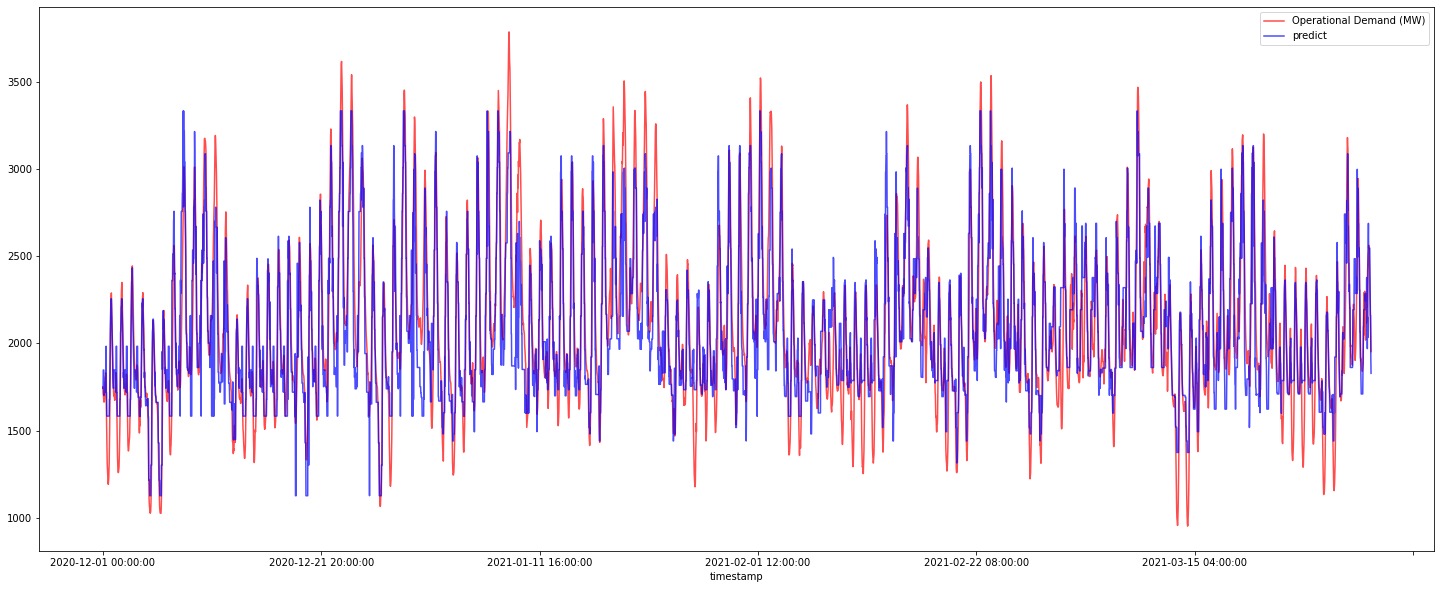

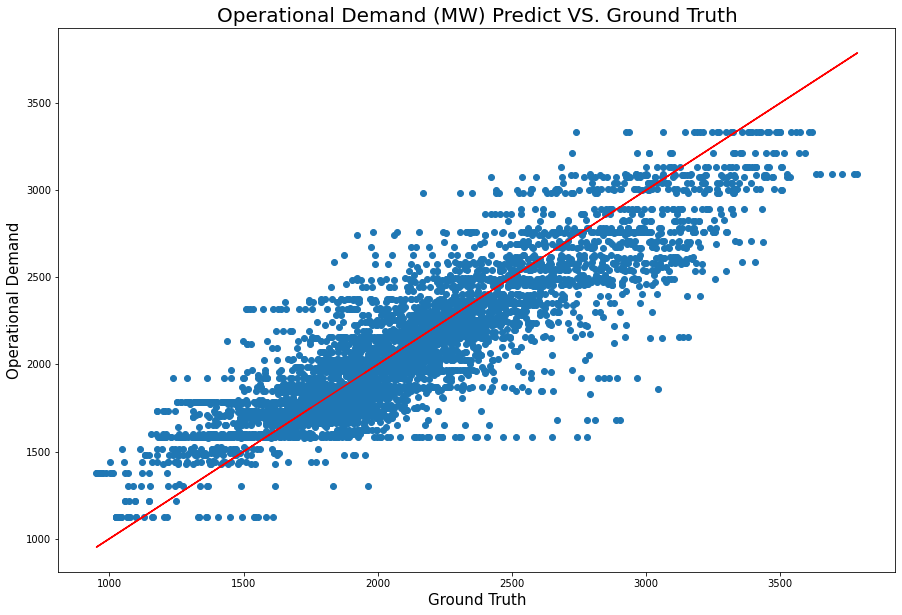

In [17]:
predict_table_tree.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(predict_table_tree['Operational Demand (MW)'], predict_table_tree['predict'])
plt.plot(predict_table_tree['Operational Demand (MW)'],predict_table_tree['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

In [18]:
predict_table_tree['Date','time'] = predict_table_tree.index.str.split(" ",expand=True)
predict_table_tree[['Date', 'time']] = predict_table_tree[('Date', 'time')].apply(pd.Series)

predict_table_tree = predict_table_tree.drop(labels=['time',('Date','time')], axis=1)
agg_tree = pd.DataFrame(predict_table_tree.groupby(['Date'])['Operational Demand (MW)','predict'].sum().reset_index())


In [19]:
peak_day = 5 # number of top peak day we choose
peak_true = agg_tree.sort_values('Operational Demand (MW)',ascending=True)[:peak_day]
truelst = peak_true.index.tolist()
peak_predict = agg_tree.sort_values('predict',ascending=True)[:peak_day]
predictlst=peak_predict.index.tolist()
acc = len([x for x in truelst if x in predictlst])/peak_day
print('Accuracy for predicting peak 5 day:',acc)

Accuracy for predicting peak 5 day: 0.8


## Random Forest

In [20]:
forest = RandomForestRegressor(criterion='mse', random_state=42)

param_grid_forest = dict(
    max_depth =[None,15,20,25],
    min_samples_leaf=[5,50,100])

grid_forest=GridSearchCV(forest, param_grid_forest, cv=3, scoring='neg_root_mean_squared_error',verbose=2,return_train_score=True)

grid_forest.fit(X_train,y_train)
y_predict_forest = grid_forest.predict(X_test)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .................max_depth=None, min_samples_leaf=5; total time=  13.2s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=  12.9s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=  12.5s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   9.1s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   9.0s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   8.9s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   8.5s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   8.9s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   7.9s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=  11.8s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=  11.6s
[CV] END ...................max_depth=15, min_sa

In [21]:
ny_test = len(y_test)
mape = (sum(np.abs((y_test - y_predict_forest)/y_test))/ny_test)*100
print('Mape', mape)
rfscore=ModelScore(y_test,y_predict_forest)
rfscore
ImportanceDisplay('grid_forest')
print(grid_forest.best_estimator_)

Mape 7.27318260473993
Mean absolute error =  147.4952
Mean squared error =  40522.6841
Median absolute error =  105.7567
explained variance error =  0.8186
R2 error =  0.8171
+----------------------+--------+
|       Factors        | Score  |
+----------------------+--------+
|     Day_of_week      | 0.208  |
|         day          | 0.0363 |
|   wind_speed(mph)    | 0.0259 |
|        minute        | 0.0076 |
|     Day_of_year      | 0.0004 |
|        month         | 0.0025 |
|     humidity(%)      | 0.0589 |
|  dew_point(celcius)  | 0.0077 |
| temperature(celcius) | 0.095  |
|    wind_gush(mph)    | 0.0329 |
|     pressure(in)     | 0.0031 |
|     Day_of_month     | 0.0076 |
|         year         | 0.5094 |
|         hour         | 0.0046 |
+----------------------+--------+
RandomForestRegressor(criterion='mse', max_depth=20, min_samples_leaf=5,
                      random_state=42)


In [22]:
y_predict_forest = pd.DataFrame(y_predict_forest)
predict_table_forest = pd.DataFrame(y_test)
predict_table_forest.insert(1,'predict',y_predict_forest)
predict_table_forest

,Operational Demand (MW),predict
timestamp,,
2020-12-01 00:00:00,1750.880,1753.833359
2020-12-01 00:30:00,1709.428,1746.740196
2020-12-01 01:00:00,1708.242,1776.498273
2020-12-01 01:30:00,1692.028,1775.182186
2020-12-01 02:00:00,1677.540,1762.242904
...,...,...
2021-03-31 21:30:00,2215.146,2349.605951
2021-03-31 22:00:00,2147.296,2179.578954
2021-03-31 22:30:00,2072.562,2141.467055


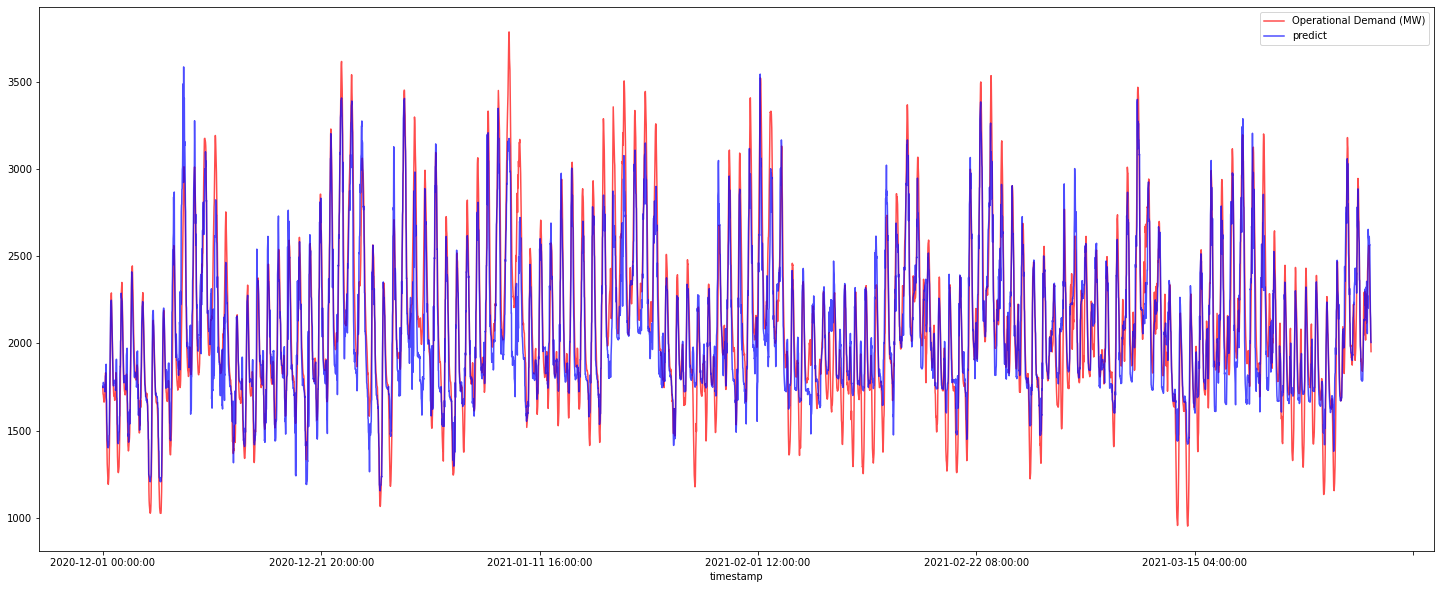

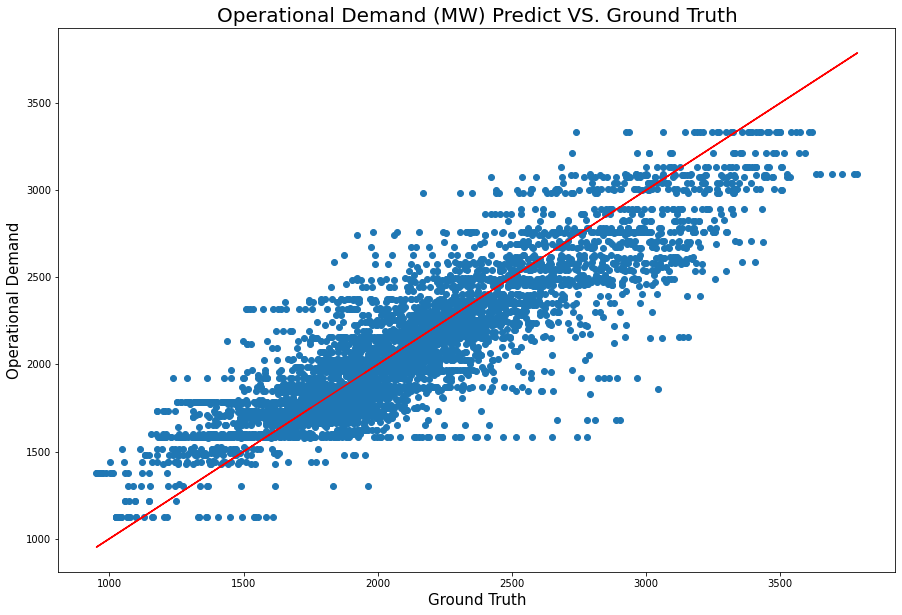

In [23]:
predict_table_forest.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(predict_table_tree['Operational Demand (MW)'], predict_table_tree['predict'])
plt.plot(predict_table_tree['Operational Demand (MW)'],predict_table_tree['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

In [24]:
predict_table_forest['Date','time'] = predict_table_forest.index.str.split(" ",expand=True)
predict_table_forest[['Date', 'time']] = predict_table_forest[('Date', 'time')].apply(pd.Series)

predict_table_forest = predict_table_forest.drop(labels=['time',('Date','time')], axis=1)
agg_forest = pd.DataFrame(predict_table_forest.groupby(['Date'])['Operational Demand (MW)','predict'].sum().reset_index())


In [25]:
peak_day = 5 # number of top peak day we choose
peak_true = agg_forest.sort_values('Operational Demand (MW)',ascending=True)[:peak_day]
truelst = peak_true.index.tolist()
peak_predict = agg_forest.sort_values('predict',ascending=True)[:peak_day]
predictlst=peak_predict.index.tolist()
acc = len([x for x in truelst if x in predictlst])/peak_day
print('Accuracy for predicting peak 5 day:',acc)

Accuracy for predicting peak 5 day: 0.8
